<a href="https://colab.research.google.com/github/surya81/Cats-and-dogs-classification-/blob/main/kaggle_cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [3]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog

cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip cat-and-dog.zip

Archive:  cat-and-dog.zip
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
train_data_dir ='/content/gdrive/MyDrive/Kaggle/training_set/training_set'
test_data_dir = '/content/gdrive/MyDrive/Kaggle/test_set/test_set'

## Import Required Library

In [15]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as f 
from torchvision import transforms,models, datasets
from PIL import Image
from torch import optim 
device = "cuda" if torch.cuda.is_available() else 'cpu'
import cv2,glob, numpy as np , pandas as pd, matplotlib.pyplot as plt 
from torch.utils.data import DataLoader,  Dataset
from glob import glob



# Building Dataset class for manually training the model weight 

In [16]:

class cats_dogs(Dataset):
  def __init__(self, folder):
    """ glob module searches all the files specified 
     which have cats+any_extra_character +.jpeg at end and stack them together in
     list"""
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)


In [17]:
data = cats_dogs(train_data_dir)
im, label = data[200]

tensor([1.], device='cuda:0')


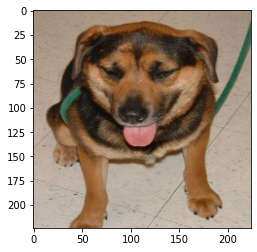

In [18]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

#Creating the model

In [19]:
def conv_layer(ni,no,kernel_size,stride =1):
  return nn.Sequential(
      nn.Conv2d(ni,no,kernel_size,stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2),
  )

In [20]:
def get_model():
  model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,1),
      nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
  return model,loss_fn,optimizer

In [32]:
from torchsummary import summary
model , loss_fn ,optimizer = get_model()
summary(model, (3, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

#Fetch data to train the model 

In [21]:
def get_data():
  train = cats_dogs(train_data_dir)
  train_dl = DataLoader(train,batch_size=32,shuffle =True,drop_last =True)
  val = cats_dogs(test_data_dir)
  val_dl = DataLoader(val,batch_size = 32,shuffle = True,drop_last =True)
  return train_dl,val_dl


### function to train the model 

In [22]:
def train_batch(x,y,model,opt,loss_fn):
  model.train()
  prediction = model(x)
  batch_loss= loss_fn(prediction,y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()


### function to get the accuracy of the model

In [26]:
@torch.no_grad()
def accuracy(x,y,model):
  prediction = model(x)
  is_correct = (prediction > 0.5)==y
  return is_correct.cpu().numpy().tolist()

### funtion to test the validation loss of data

In [24]:
def val_loss(x,y,model):
  prediction = model(x)
  val_loss = loss_fn(prediction,y)
  return val_loss.item()

# Initialize the parameter


In [27]:
train_dl,val_dl = get_data()
model,loss_fn,optimizer = get_model()
train_loss,train_accuracies = [],[]
val_loss,val_accuracies = [],[]
for epoch in range(5):
  train_epoch_losses,train_epoch_accuracies =[],[]
  val_epoch_accuracies =[]
  for ix,batch in enumerate(iter(train_dl)):
    x,y = batch
    batch_loss =train_batch(x,y,model,optimizer,loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_losses =np.array(train_epoch_losses).mean()

  for ix ,batch in enumerate(iter(train_dl)):
    x,y = batch 
    is_correct = accuracy(x,y,model)
    train_epoch_accuracies.append(is_correct)

  train_epoch_accuracies = np.array(train_epoch_accuracies).mean()

  for ix , batch in enumerate(iter(val_dl)):
    x,y = batch 
    val_is_correct = accuracy(x,y,model)
    val_epoch_accuracies.append(val_is_correct)

  val_epoch_accuracies = np.array(val_epoch_accuracies).mean()

  train_loss.append(train_epoch_losses)
  train_accuracies.append(train_epoch_accuracies)
  val_accuracies.append(val_epoch_accuracies)





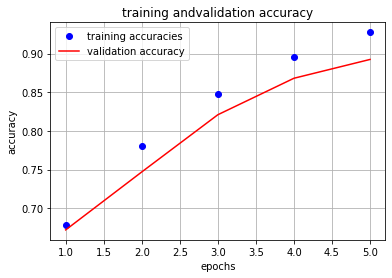

In [29]:
epochs = np.arange(5)+1
plt.plot(epochs,train_accuracies,'bo',label = "training accuracies")
plt.plot(epochs,val_accuracies,'r',label = "validation accuracy")
plt.title("training andvalidation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid("off")
plt.show()